In [16]:
import pandas as pd
import numpy as np
df = pd.read_csv('./dataset/TCurieData.csv', na_values=0)
df = df.rename(columns={'Composition': 'formula'})

In [17]:
df.head()

,formula,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K)
0,Fe69.5Co0.5Mn10Mo5B15,NaN,NaN,20.0,370.00000
1,Fe80Ni6Zr7Nb2B4Cu1,NaN,NaN,20.0,374.00000
2,Fe90Zr7B3,3600.0,873.25952,20.0,388.64693
3,Fe69.5Co0.5Mn10Mo5B15,1800.0,723.00000,20.0,389.00000
4,Fe90Zr7B3,3600.0,822.85321,20.0,389.68647


In [18]:
df.describe()

,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K)
count,98.000000,98.000000,220.000000,220.000000
mean,1668.527573,735.758597,21.677273,599.232518
std,1439.796336,74.034270,3.351607,73.767177
min,60.000000,573.000000,17.500000,370.000000
25%,240.000000,679.500000,20.000000,587.000000
50%,1800.000000,745.514655,20.000000,605.983795
75%,3600.000000,780.500000,22.500000,626.768258
max,3857.047930,924.632090,30.000000,769.000000


In [19]:
from utils import add_feature

df = add_feature.add_composition(df)
#df = add_feature.add_element_fraction(df)
df = add_feature.add_Wen_alloys(df)
#df = add_feature.add_Yang_alloys(df)
#df = add_feature.add_valence_orbitals(df)
#df = add_feature.add_magpie(df)

StrToComposition: 100%|████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 1860.75it/s]
/Users/jingsk/miniconda3/envs/matminer-phaseshift/lib/python3.10/site-packages/matminer/utils/data.py:281: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mixing_dataset = pd.read_csv(
/Users/jingsk/miniconda3/envs/matminer-phaseshift/lib/python3.10/site-packages/matminer/utils/data.py:281: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mixing_dataset = pd.read_csv(
WenAlloys: 100%|█████████████████████████████████████████████████████████████████████| 220/220 [00:25<00:00,  8.47it/s]


In [20]:
df.head()

,formula,Annealing Time (s),Annealing Temperature (K),Thickness (mu m),Tc (K),composition,Weight Fraction,Atomic Fraction,Yang delta,Yang omega,...,Mean cohesive energy,Interant electrons,Interant s electrons,Interant p electrons,Interant d electrons,Interant f electrons,Shear modulus mean,Shear modulus delta,Shear modulus local mismatch,Shear modulus strength model
0,Fe69.5Co0.5Mn10Mo5B15,NaN,NaN,20.0,370.00000,"(Fe, Co, Mn, Mo, B)",Fe0.7607356896068751 Co0.005775567747453794 Mn...,Fe0.695Co0.005Mn0.1Mo0.05B0.15,0.117847,1.069647,...,4.50105,25.0,1.0,1.0,23.0,0,100.9455,0.431954,17.085923,-0.063532
1,Fe80Ni6Zr7Nb2B4Cu1,NaN,NaN,20.0,374.00000,"(Fe, Ni, Zr, Nb, B, Cu)",Fe0.776848109585092 Ni0.061235370447383336 Zr0...,Fe0.8Ni0.06Zr0.07Nb0.02B0.04Cu0.01,0.092348,1.006013,...,4.54660,23.0,2.0,1.0,20.0,0,81.4335,0.347972,9.075177,-0.046497
2,Fe90Zr7B3,3600.0,873.25952,20.0,388.64693,"(Fe, Zr, B)",Fe0.8822195904512703 Zr0.11208746419858273 B0....,Fe0.9Zr0.07B0.03,0.085292,0.611824,...,4.46380,9.0,0.0,1.0,8.0,0,81.8508,0.299383,6.622416,-0.034404
3,Fe69.5Co0.5Mn10Mo5B15,1800.0,723.00000,20.0,389.00000,"(Fe, Co, Mn, Mo, B)",Fe0.7607356896068751 Co0.005775567747453794 Mn...,Fe0.695Co0.005Mn0.1Mo0.05B0.15,0.117847,1.069647,...,4.50105,25.0,1.0,1.0,23.0,0,100.9455,0.431954,17.085923,-0.063532
4,Fe90Zr7B3,3600.0,822.85321,20.0,389.68647,"(Fe, Zr, B)",Fe0.8822195904512703 Zr0.11208746419858273 B0....,Fe0.9Zr0.07B0.03,0.085292,0.611824,...,4.46380,9.0,0.0,1.0,8.0,0,81.8508,0.299383,6.622416,-0.034404


In [21]:
from sklearn.model_selection import train_test_split

X = df.drop(['Tc (K)', 
             'composition',
             'formula'], axis =1)
#for Wens Alloy
try:
    X = X.drop(['Atomic Fraction',
                'Weight Fraction'], axis=1)
except KeyError:
    pass

y = df['Tc (K)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor(n_estimators=50, random_state=1)

rf.fit(X_train, y_train)
print(f'training R2 = {rf.score(X_train, y_train): .03f}')
print(f'training RMSE = {np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf.predict(X_train))):.3f}')

print(f'test R2 = {rf.score(X_test, y_test): .03f}')
print(f'test RMSE = {np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf.predict(X_test))):.3f}')

training R2 =  0.961
training RMSE = 14.259
test R2 =  0.810
test RMSE = 34.647


In [23]:
from sklearn.model_selection import KFold, cross_val_score
# compute cross validation scores for random forest model
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
r2_scores = cross_val_score(rf, X_train, y_train, scoring='r2', cv=crossvalidation, n_jobs=-1)
scores = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 5, mean R2: 0.572
Folds: 5, mean RMSE: 39.990


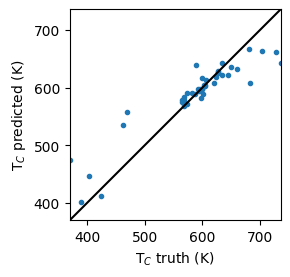

In [24]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

fig, ax = plt.subplots(figsize=[3,3])

y_predicted = rf.predict(X_test)
ax.plot(y_test, y_predicted, '.')
ymin, ymax = np.min([y_test, y_predicted]), np.max([y_test, y_predicted])
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
ax.axline((0, 0), slope=1, color='k')
loc = plticker.AutoLocator() # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.set_xlabel(r'T$_{C}$ truth (K)')
ax.set_ylabel(r'T$_{C}$ predicted (K)')
ax.set_aspect('equal', 'box')
fig.tight_layout()
fig.savefig('rf.png', dpi=300)

In [25]:
importances = rf.feature_importances_
# included = np.asarray(included)
included = X.columns.values
indices = np.argsort(importances)[::-1]

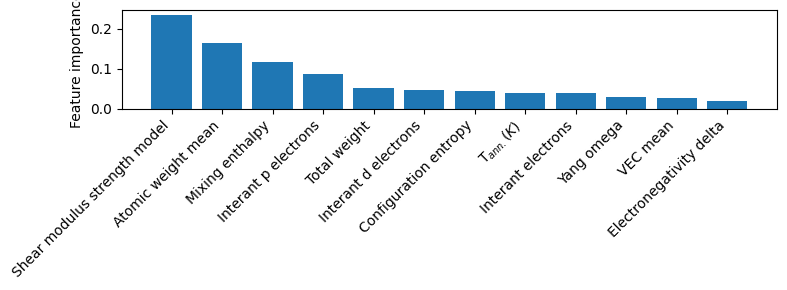

In [26]:
fig, ax = plt.subplots(figsize=[8,3])

features = included[indices][0:12]
scores = importances[indices][0:12]

features[features=='Annealing Temperature (K)'] = r'T$_{ann.} (K)$'
features[features=='Thickness (mu m)'] = 'Thic. ($\mu$m)'
features[features=='Annealing Time (s)'] = r't$_{ann.} (s)$'

ax.bar(features, scores)
ax.set_ylabel('Feature importance')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.savefig('feat_weights.png', dpi=300)

In [28]:
df['Yang omega']

0      1.069647
1      1.006013
2      0.611824
3      1.069647
4      0.611824
         ...   
215    0.506469
216    0.570565
217    0.848094
218    0.440304
219    0.570565
Name: Yang omega, Length: 220, dtype: float64